# BAN5600 Advanced Big Data Computing & Programming Final Project

NFL Big Data Bowl 2021-Evaluation on passing plays of the defensive team

Team member: Yi-Hsuan Tsai, Yuxiu Wang

Instructor: Dr. Hamidreza Ahady Dolatsara

Data: https://www.kaggle.com/c/nfl-big-data-bowl-2021/data

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('myproj').getOrCreate()

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib.pyplot import figure

In [0]:
sp_game = spark.read.csv('/FileStore/tables/games.csv',inferSchema=True,header=True)
sp_play = spark.read.csv('/FileStore/tables/plays.csv',inferSchema=True,header=True)
sp_player = spark.read.csv('/FileStore/tables/players.csv',inferSchema=True,header=True)
sp_week1 = spark.read.csv('/FileStore/tables/week1.csv',inferSchema=True,header=True)
sp_playbyplay = spark.read.csv('/FileStore/tables/play_by_play_2018_3.csv', inferSchema=True,header=True)

# 1. Game Data
The games.csv contains the teams playing in each game. The key variable is gameId.

gameId: Game identifier, unique (numeric)

gameDate: Game Date (time, mm/dd/yyyy)

gameTimeEastern: Start time of game (time, HH:MM:SS, EST)

homeTeamAbbr: Home team three-letter code (text)

visitorTeamAbbr: Visiting team three-letter code (text)

week: Week of game (numeric)

In [0]:
sp_game.printSchema()

root
-- gameId: integer (nullable = true)
-- gameDate: string (nullable = true)
-- gameTimeEastern: string (nullable = true)
-- homeTeamAbbr: string (nullable = true)
-- visitorTeamAbbr: string (nullable = true)
-- week: integer (nullable = true)

In [0]:
sp_game.show()

+----------+----------+---------------+------------+---------------+----+
 gameId| gameDate|gameTimeEastern|homeTeamAbbr|visitorTeamAbbr|week|
+----------+----------+---------------+------------+---------------+----+
2018090600|09/06/2018| 20:20:00| PHI| ATL| 1|
2018090901|09/09/2018| 13:00:00| CLE| PIT| 1|
2018090902|09/09/2018| 13:00:00| IND| CIN| 1|
2018090903|09/09/2018| 13:00:00| MIA| TEN| 1|
2018090900|09/09/2018| 13:00:00| BAL| BUF| 1|
2018090905|09/09/2018| 13:00:00| NE| HOU| 1|
2018090907|09/09/2018| 13:00:00| NYG| JAX| 1|
2018090906|09/09/2018| 13:00:00| NO| TB| 1|
2018090909|09/09/2018| 16:25:00| ARI| WAS| 1|
2018090910|09/09/2018| 16:25:00| CAR| DAL| 1|
2018090912|09/09/2018| 20:20:00| GB| CHI| 1|
2018091000|09/10/2018| 19:10:00| DET| NYJ| 1|
2018091001|09/10/2018| 22:20:00| OAK| LA| 1|
2018091300|09/13/2018| 20:20:00| CIN| BAL| 2|
2018091602|09/16/2018| 13:00:00| GB| MIN| 2|
2018091603|09/16/2018| 13:00:00| NO| CLE| 2|
2018091604|09/16/2018| 13:00:00| NYJ| MIA| 2|
2018091601|09/16/2018| 13:00:00| BUF| LAC| 2|
2018091600|09/16/2018| 13:00:00| ATL| CAR| 2|
2018091605|09/16/2018| 13:00:00| PIT| KC| 2|
+----------+----------+---------------+------------+---------------+----+
only showing top 20 rows

In [0]:
#Check missing value
from pyspark.sql.functions import *
from pyspark.sql.functions import when, count, col
sp_game.select([count(when(isnull(c), c)).alias(c) for c in sp_game.columns]).show()
#There is no missing value is the game data

+------+--------+---------------+------------+---------------+----+
gameId|gameDate|gameTimeEastern|homeTeamAbbr|visitorTeamAbbr|week|
+------+--------+---------------+------------+---------------+----+
 0| 0| 0| 0| 0| 0|
+------+--------+---------------+------------+---------------+----+

## How many games are there every day?

In [0]:
import pandas as pd 
import numpy as np 
sp_game.createOrReplaceTempView('sp_game')#For SQL
sp_game.registerTempTable("sp_game")#For Visualization

In [0]:
results = spark.sql("SELECT gameDate, count(*) AS Number_of_Game FROM sp_game GROUP BY gameDate ORDER BY Number_of_Game DESC" )
results.show()

+----------+--------------+
 gameDate|Number_of_Game|
+----------+--------------+
12/30/2018| 16|
09/23/2018| 14|
12/02/2018| 14|
09/16/2018| 14|
12/09/2018| 14|
09/30/2018| 13|
10/14/2018| 13|
10/07/2018| 13|
12/23/2018| 13|
12/16/2018| 12|
11/11/2018| 12|
10/28/2018| 12|
10/21/2018| 12|
11/04/2018| 11|
11/18/2018| 11|
11/25/2018| 11|
09/09/2018| 10|
11/22/2018| 3|
12/15/2018| 2|
09/10/2018| 2|
+----------+--------------+
only showing top 20 rows

In [0]:
display(sqlContext.sql("select * from sp_game"))

gameId,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week
2018090600,09/06/2018,20:20:00,PHI,ATL,1
2018090901,09/09/2018,13:00:00,CLE,PIT,1
2018090902,09/09/2018,13:00:00,IND,CIN,1
2018090903,09/09/2018,13:00:00,MIA,TEN,1
2018090900,09/09/2018,13:00:00,BAL,BUF,1
2018090905,09/09/2018,13:00:00,NE,HOU,1
2018090907,09/09/2018,13:00:00,NYG,JAX,1
2018090906,09/09/2018,13:00:00,NO,TB,1
2018090909,09/09/2018,16:25:00,ARI,WAS,1
2018090910,09/09/2018,16:25:00,CAR,DAL,1


## How many games grouped by time?
Mos of the game were held on 13:00

In [0]:
display(sqlContext.sql("select * from sp_game"))

gameId,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week
2018090600,09/06/2018,20:20:00,PHI,ATL,1
2018090901,09/09/2018,13:00:00,CLE,PIT,1
2018090902,09/09/2018,13:00:00,IND,CIN,1
2018090903,09/09/2018,13:00:00,MIA,TEN,1
2018090900,09/09/2018,13:00:00,BAL,BUF,1
2018090905,09/09/2018,13:00:00,NE,HOU,1
2018090907,09/09/2018,13:00:00,NYG,JAX,1
2018090906,09/09/2018,13:00:00,NO,TB,1
2018090909,09/09/2018,16:25:00,ARI,WAS,1
2018090910,09/09/2018,16:25:00,CAR,DAL,1


# 2. Player Data
The players.csv file contains player-level information from players that participated in any of the tracking data files. The key variable is **nflId**.

nflId: Player identification number, unique across players (numeric)

height: Player height (text)

weight: Player weight (numeric)

birthDate: Date of birth (YYYY-MM-DD)

collegeName: Player college (text)

position: Player position (text)

displayName: Player name (text)

In [0]:
sp_player.show()

+-------+------+------+----------+--------------------+--------+------------------+
 nflId|height|weight| birthDate| collegeName|position| displayName|
+-------+------+------+----------+--------------------+--------+------------------+
2539334| 72| 190|1990-09-10| Washington| CB| Desmond Trufant|
2539653| 70| 186|1988-11-01|Southeastern Loui...| CB| Robert Alford|
2543850| 69| 186|1991-12-18| Purdue| SS| Ricardo Allen|
2555162| 73| 227|1994-11-04| Louisiana State| MLB| Deion Jones|
2555255| 75| 232|1993-07-01| Minnesota| OLB|De'Vondre Campbell|
2555543| 73| 216|1995-07-26| Florida| FS| Keanu Neal|
2556445| 70| 211|1992-10-20| Florida| CB| Brian Poole|
2507763| 6-0| 200|08/01/1986| Mississippi| WR| Mike Wallace|
2532842| 78| 243|1989-01-20| Arizona| QB| Nick Foles|
2540158| 77| 250|1990-11-10| Stanford| TE| Zach Ertz|
2552582| 6-0| 223|06/15/1993| Boise State| RB| Jay Ajayi|
2552600| 72| 198|1993-05-24| Southern California| WR| Nelson Agholor|
2553502| 68| 190|1993-04-10| Sacramento State| WR| DeAndre Carter|
2552301| 75| 246|1992-07-08| Clemson| DE| Vic Beasley|
2506467| 66| 190|1983-06-20| Kansas State| RB| Darren Sproles|
2557967| 73| 230|1994-08-09| Louisiana State| OLB| Duke Riley|
2558184| 71| 190|1993-06-05| San Diego State| SS| Damontae Kazee|
2560995| 77| 256|1995-01-03| South Dakota State| TE| Dallas Goedert|
2559150| 70| 220|1994-11-02| Wisconsin| RB| Corey Clement|
 310| 76| 217|1985-05-17| Boston College| QB| Matt Ryan|
+-------+------+------+----------+--------------------+--------+------------------+
only showing top 20 rows

In [0]:
#Transfer spark dataframe into pandas dataframe
df_player = sp_player.select('*').toPandas()

,nflId,height,weight,birthDate,collegeName,position,displayName
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell


## Feature Engineering

In [0]:
#Identify defensive player and offensive palyer
def defensive_player(df_player):
  if df_player['position'] in ('OLB', 'ILB', 'DB', 'FS', 'LB','MLB','DE','S','CB','SS','NT', 'DT'):
    return "Defensive"
  else:
    return "Offensive"

df_player['if_defense'] = df_player.apply(defensive_player, axis=1)

,nflId,height,weight,birthDate,collegeName,position,displayName,if_defense
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant,Defensive
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford,Defensive
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen,Defensive
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones,Defensive
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell,Defensive


In [0]:
df_player['position_revised'] = df_player['position']

,nflId,height,weight,birthDate,collegeName,position,displayName,if_defense,position_revised
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant,Defensive,CB
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford,Defensive,CB
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen,Defensive,SS
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones,Defensive,MLB
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell,Defensive,OLB


In [0]:
#Regroup position_revised
#Regroup defensive position
#Group (LB, OLB, ILB, and MLB) into 'Linebacker' category
#Group (S, SS, FS) into 'Safety'
#Group (NT) into 'Defensive Tackle'
#Group (CB) into 'Cornerback'
#Group (DB) into 'Defensive Back'
#Group (DE) into 'Defensive End'
def posotion_regroup(df_player):
  if df_player['position_revised'] in ('OLB', 'ILB', 'LB', 'MLB'):
    return "Linebacker"
  elif df_player['position_revised'] in ('S', 'SS', 'FS'):
    return "Safety"
  elif df_player['position_revised'] in ('NT', 'DT'):
    return "Defensive Tackle"  
  elif df_player['position_revised'] in ('CB'):
    return "Cornerback"  
  elif df_player['position_revised'] in ('DB'):
    return "Defensive Back"  
  else:
    return "Defensive End"

df_player['position_revised2'] = df_player.apply(posotion_regroup, axis=1)
df_player.drop(columns=['position_revised'])

,nflId,height,weight,birthDate,collegeName,position,displayName,if_defense,position_revised,position_revised2
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant,Defensive,CB,Cornerback
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford,Defensive,CB,Cornerback
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen,Defensive,SS,Safety
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones,Defensive,MLB,Linebacker
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell,Defensive,OLB,Linebacker


In [0]:
#Convert pd dataframe into spark dataframe
sp_player = spark.createDataFrame(df_player)

## We can see that the height of player has two different measurement: inches and feet&inches, therefore, we convert all values into feet.

In [0]:
#Convert height's value into feet
players=sp_player.select("*").toPandas()
players.head(5)

,nflId,height,weight,birthDate,collegeName,position,displayName,if_defense,position_revised,position_revised2
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant,Defensive,CB,Cornerback
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford,Defensive,CB,Cornerback
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen,Defensive,SS,Safety
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones,Defensive,MLB,Linebacker
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell,Defensive,OLB,Linebacker


In [0]:
check = players['height'].str.split('-',expand=True)
check.columns = ['first', 'second']
check.loc[(check['second'].notnull()), 'first'] = check[check['second'].notnull()]['first'].astype(np.int16) * 12 + check[check['second'].notnull()]['second'].astype(np.int16)

In [0]:
players['height'] = check['first']
players['height'] = players['height'].astype(np.float32)
players['height'] /= 12

players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName,if_defense,position_revised,position_revised2
0,2539334,6.000000,190,1990-09-10,Washington,CB,Desmond Trufant,Defensive,CB,Cornerback
1,2539653,5.833333,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford,Defensive,CB,Cornerback
2,2543850,5.750000,186,1991-12-18,Purdue,SS,Ricardo Allen,Defensive,SS,Safety
3,2555162,6.083333,227,1994-11-04,Louisiana State,MLB,Deion Jones,Defensive,MLB,Linebacker
4,2555255,6.250000,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell,Defensive,OLB,Linebacker


In [0]:
def calculate_age(birthDate):
    """"Create age based on given birthDate."""
    today = pd.to_datetime('today')
    return (today - birthDate).days / 365.25

# Birth dates formatted by simple applying pandas to_datetime function.
players["birthDate"] = pd.to_datetime(players["birthDate"])

# Create age column based on birthDate.
players["age"] = players["birthDate"].apply(calculate_age)

In [0]:
#Back to spark dataframe
sp_player=spark.createDataFrame(players)
sp_player.show(5)

+-------+---------+------+-------------------+--------------------+--------+------------------+----------+----------------+-----------------+------------------+
 nflId| height|weight| birthDate| collegeName|position| displayName|if_defense|position_revised|position_revised2| age|
+-------+---------+------+-------------------+--------------------+--------+------------------+----------+----------------+-----------------+------------------+
2539334| 6.0| 190|1990-09-10 00:00:00| Washington| CB| Desmond Trufant| Defensive| CB| Cornerback| 30.17659137577002|
2539653|5.8333335| 186|1988-11-01 00:00:00|Southeastern Loui...| CB| Robert Alford| Defensive| CB| Cornerback| 32.03285420944559|
2543850| 5.75| 186|1991-12-18 00:00:00| Purdue| SS| Ricardo Allen| Defensive| SS| Safety|28.906228610540726|
2555162|6.0833335| 227|1994-11-04 00:00:00| Louisiana State| MLB| Deion Jones| Defensive| MLB| Linebacker|26.026009582477755|
2555255| 6.25| 232|1993-07-01 00:00:00| Minnesota| OLB|De'Vondre Campbell| Defensive| OLB| Linebacker|27.370294318959616|
+-------+---------+------+-------------------+--------------------+--------+------------------+----------+----------------+-----------------+------------------+
only showing top 5 rows

In [0]:
sp_player.select("height", 'weight','age').describe().show()

+-------+------------------+------------------+------------------+
summary| height| weight| age|
+-------+------------------+------------------+------------------+
 count| 1303| 1303| 1303|
 mean|6.1016884106264975|222.53722179585571| 28.46437773515864|
 stddev|0.2050858628757517|29.476746865848657|3.2393918210549564|
 min| 5.5| 159|22.535249828884325|
 max| 6.6666665| 352|43.279945242984255|
+-------+------------------+------------------+------------------+

## Filter the data only with defensive team

In [0]:
sp_player_def = sp_player.filter(sp_player.if_defense=="Defensive")

In [0]:
sp_player_def.select("height", 'weight','age').describe().show()

+-------+-------------------+------------------+------------------+
summary| height| weight| age|
+-------+-------------------+------------------+------------------+
 count| 687| 687| 687|
 mean| 6.084667632673505|224.72052401746726|28.334013810803352|
 stddev|0.17183506594724993|33.502846591807085|3.0381812277970464|
 min| 5.6666665| 159|22.535249828884325|
 max| 6.6666665| 352| 40.82135523613963|
+-------+-------------------+------------------+------------------+

## The distribution of weight and height of players

In [0]:
sp_player_def.createOrReplaceTempView('sp_player_def')#For SQL
sp_player_def.registerTempTable("sp_player_def")#For Visualization

## Defensive player's height distribution
According to player's height distribution, we can see that most of the defensive player’s heights are around 5.9 feet to 6.1 feet, and the height distribution of defensive players is close to normally distributed.

In [0]:
height_distribution = spark.sql('SELECT height FROM sp_player_def ORDER BY height')
height_distribution.registerTempTable("height_distribution")
display(sqlContext.sql("select * from height_distribution"))

height
5.6666665
5.6666665
5.75
5.75
5.75
5.75
5.75
5.75
5.75
5.75


## Player's weight distribution
According to player's weigh distribution, we can see that most of the defensive player’s weight are around 190 to 200

In [0]:
sp_player_def.registerTempTable("sp_player_def")
display(sqlContext.sql("select * from sp_player_def"))

nflId,height,weight,birthDate,collegeName,position,displayName,if_defense,position_revised,position_revised2,age
2539334,6.0,190,1990-09-10T00:00:00.000+0000,Washington,CB,Desmond Trufant,Defensive,CB,Cornerback,30.17659137577002
2539653,5.8333335,186,1988-11-01T00:00:00.000+0000,Southeastern Louisiana,CB,Robert Alford,Defensive,CB,Cornerback,32.03285420944559
2543850,5.75,186,1991-12-18T00:00:00.000+0000,Purdue,SS,Ricardo Allen,Defensive,SS,Safety,28.906228610540726
2555162,6.0833335,227,1994-11-04T00:00:00.000+0000,Louisiana State,MLB,Deion Jones,Defensive,MLB,Linebacker,26.026009582477755
2555255,6.25,232,1993-07-01T00:00:00.000+0000,Minnesota,OLB,De'Vondre Campbell,Defensive,OLB,Linebacker,27.370294318959616
2555543,6.0833335,216,1995-07-26T00:00:00.000+0000,Florida,FS,Keanu Neal,Defensive,FS,Safety,25.30321697467488
2556445,5.8333335,211,1992-10-20T00:00:00.000+0000,Florida,CB,Brian Poole,Defensive,CB,Cornerback,28.06570841889117
2552301,6.25,246,1992-07-08T00:00:00.000+0000,Clemson,DE,Vic Beasley,Defensive,DE,Defensive End,28.35044490075291
2557967,6.0833335,230,1994-08-09T00:00:00.000+0000,Louisiana State,OLB,Duke Riley,Defensive,OLB,Linebacker,26.26420260095825
2558184,5.9166665,190,1993-06-05T00:00:00.000+0000,San Diego State,SS,Damontae Kazee,Defensive,SS,Safety,27.44147843942505


## Player's age grouped by their position
According to the plot below, it indicates that most positions’ average age is around 28-30; however, players who belong to defensive back are relatively younger, which is around 26.

In [0]:
sp_player_def.registerTempTable("sp_player_def")
display(sqlContext.sql("select * from sp_player_def"))

nflId,height,weight,birthDate,collegeName,position,displayName,if_defense,position_revised,position_revised2,age
2539334,6.0,190,1990-09-10T00:00:00.000+0000,Washington,CB,Desmond Trufant,Defensive,CB,Cornerback,30.17659137577002
2539653,5.8333335,186,1988-11-01T00:00:00.000+0000,Southeastern Louisiana,CB,Robert Alford,Defensive,CB,Cornerback,32.03285420944559
2543850,5.75,186,1991-12-18T00:00:00.000+0000,Purdue,SS,Ricardo Allen,Defensive,SS,Safety,28.906228610540726
2555162,6.0833335,227,1994-11-04T00:00:00.000+0000,Louisiana State,MLB,Deion Jones,Defensive,MLB,Linebacker,26.026009582477755
2555255,6.25,232,1993-07-01T00:00:00.000+0000,Minnesota,OLB,De'Vondre Campbell,Defensive,OLB,Linebacker,27.370294318959616
2555543,6.0833335,216,1995-07-26T00:00:00.000+0000,Florida,FS,Keanu Neal,Defensive,FS,Safety,25.30321697467488
2556445,5.8333335,211,1992-10-20T00:00:00.000+0000,Florida,CB,Brian Poole,Defensive,CB,Cornerback,28.06570841889117
2552301,6.25,246,1992-07-08T00:00:00.000+0000,Clemson,DE,Vic Beasley,Defensive,DE,Defensive End,28.35044490075291
2557967,6.0833335,230,1994-08-09T00:00:00.000+0000,Louisiana State,OLB,Duke Riley,Defensive,OLB,Linebacker,26.26420260095825
2558184,5.9166665,190,1993-06-05T00:00:00.000+0000,San Diego State,SS,Damontae Kazee,Defensive,SS,Safety,27.44147843942505


## Player's height/weight grouped by their position
In addition to age, we also create height box plots and weight box plots for each defensive position. Combining the height and weight box plots, we can see that Defensive Tackle and Defensive End are relatively higher and heavier, and cornerback is the smallest and lightest one.

In [0]:
sp_player_def.registerTempTable("sp_player_def")
display(sqlContext.sql("select * from sp_player_def"))

nflId,height,weight,birthDate,collegeName,position,displayName,if_defense,position_revised,position_revised2,age
2539334,6.0,190,1990-09-10T00:00:00.000+0000,Washington,CB,Desmond Trufant,Defensive,CB,Cornerback,30.17659137577002
2539653,5.8333335,186,1988-11-01T00:00:00.000+0000,Southeastern Louisiana,CB,Robert Alford,Defensive,CB,Cornerback,32.03285420944559
2543850,5.75,186,1991-12-18T00:00:00.000+0000,Purdue,SS,Ricardo Allen,Defensive,SS,Safety,28.906228610540726
2555162,6.0833335,227,1994-11-04T00:00:00.000+0000,Louisiana State,MLB,Deion Jones,Defensive,MLB,Linebacker,26.026009582477755
2555255,6.25,232,1993-07-01T00:00:00.000+0000,Minnesota,OLB,De'Vondre Campbell,Defensive,OLB,Linebacker,27.370294318959616
2555543,6.0833335,216,1995-07-26T00:00:00.000+0000,Florida,FS,Keanu Neal,Defensive,FS,Safety,25.30321697467488
2556445,5.8333335,211,1992-10-20T00:00:00.000+0000,Florida,CB,Brian Poole,Defensive,CB,Cornerback,28.06570841889117
2552301,6.25,246,1992-07-08T00:00:00.000+0000,Clemson,DE,Vic Beasley,Defensive,DE,Defensive End,28.35044490075291
2557967,6.0833335,230,1994-08-09T00:00:00.000+0000,Louisiana State,OLB,Duke Riley,Defensive,OLB,Linebacker,26.26420260095825
2558184,5.9166665,190,1993-06-05T00:00:00.000+0000,San Diego State,SS,Damontae Kazee,Defensive,SS,Safety,27.44147843942505


In [0]:
sp_player_def.registerTempTable("sp_player_def")
display(sqlContext.sql("select * from sp_player_def"))

nflId,height,weight,birthDate,collegeName,position,displayName,if_defense,position_revised,position_revised2,age
2539334,6.0,190,1990-09-10T00:00:00.000+0000,Washington,CB,Desmond Trufant,Defensive,CB,Cornerback,30.17659137577002
2539653,5.8333335,186,1988-11-01T00:00:00.000+0000,Southeastern Louisiana,CB,Robert Alford,Defensive,CB,Cornerback,32.03285420944559
2543850,5.75,186,1991-12-18T00:00:00.000+0000,Purdue,SS,Ricardo Allen,Defensive,SS,Safety,28.906228610540726
2555162,6.0833335,227,1994-11-04T00:00:00.000+0000,Louisiana State,MLB,Deion Jones,Defensive,MLB,Linebacker,26.026009582477755
2555255,6.25,232,1993-07-01T00:00:00.000+0000,Minnesota,OLB,De'Vondre Campbell,Defensive,OLB,Linebacker,27.370294318959616
2555543,6.0833335,216,1995-07-26T00:00:00.000+0000,Florida,FS,Keanu Neal,Defensive,FS,Safety,25.30321697467488
2556445,5.8333335,211,1992-10-20T00:00:00.000+0000,Florida,CB,Brian Poole,Defensive,CB,Cornerback,28.06570841889117
2552301,6.25,246,1992-07-08T00:00:00.000+0000,Clemson,DE,Vic Beasley,Defensive,DE,Defensive End,28.35044490075291
2557967,6.0833335,230,1994-08-09T00:00:00.000+0000,Louisiana State,OLB,Duke Riley,Defensive,OLB,Linebacker,26.26420260095825
2558184,5.9166665,190,1993-06-05T00:00:00.000+0000,San Diego State,SS,Damontae Kazee,Defensive,SS,Safety,27.44147843942505


## Scatterplot of weight and height clustered by player's position
To see the difference between the six clusters, we also create a scatterplot of weight and height based on six different categories to derive more insight. According to Figure below,  the players’ wright range is broad, ranging from 160 to 350. We can see that some cluster structures are apparent, Defensive Tackles and Defensive Backs are in the upper-right place, and Cornerbacks are placed in the lower-left area. This situation is reasonable and can reflect what their duty is in the game. 

Defensive Tackles and Defensive End are usually enormous because they play at the forefront of the line of scrimmage. Their job is to rush and attack the passer and stop offensive runs. On the other hand, Cornerbacks are relatively small and light since they need to run fast and be agile to prevent successful passes.

In [0]:
sp_player_def.registerTempTable("sp_player_def")
display(sqlContext.sql("select * from sp_player_def"))

nflId,height,weight,birthDate,collegeName,position,displayName,if_defense,position_revised,position_revised2,age
2539334,6.0,190,1990-09-10T00:00:00.000+0000,Washington,CB,Desmond Trufant,Defensive,CB,Cornerback,30.17659137577002
2539653,5.8333335,186,1988-11-01T00:00:00.000+0000,Southeastern Louisiana,CB,Robert Alford,Defensive,CB,Cornerback,32.03285420944559
2543850,5.75,186,1991-12-18T00:00:00.000+0000,Purdue,SS,Ricardo Allen,Defensive,SS,Safety,28.906228610540726
2555162,6.0833335,227,1994-11-04T00:00:00.000+0000,Louisiana State,MLB,Deion Jones,Defensive,MLB,Linebacker,26.026009582477755
2555255,6.25,232,1993-07-01T00:00:00.000+0000,Minnesota,OLB,De'Vondre Campbell,Defensive,OLB,Linebacker,27.370294318959616
2555543,6.0833335,216,1995-07-26T00:00:00.000+0000,Florida,FS,Keanu Neal,Defensive,FS,Safety,25.30321697467488
2556445,5.8333335,211,1992-10-20T00:00:00.000+0000,Florida,CB,Brian Poole,Defensive,CB,Cornerback,28.06570841889117
2552301,6.25,246,1992-07-08T00:00:00.000+0000,Clemson,DE,Vic Beasley,Defensive,DE,Defensive End,28.35044490075291
2557967,6.0833335,230,1994-08-09T00:00:00.000+0000,Louisiana State,OLB,Duke Riley,Defensive,OLB,Linebacker,26.26420260095825
2558184,5.9166665,190,1993-06-05T00:00:00.000+0000,San Diego State,SS,Damontae Kazee,Defensive,SS,Safety,27.44147843942505


# 3. Brief review of the tracking data

In [0]:
pip install missingno

Python interpreter will be restarted.
Collecting missingno
 Downloading missingno-0.4.2-py3-none-any.whl (9.7 kB)
Requirement already satisfied: seaborn in /databricks/python3/lib/python3.7/site-packages (from missingno) (0.10.0)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.7/site-packages (from missingno) (3.1.3)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.7/site-packages (from missingno) (1.18.1)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.7/site-packages (from missingno) (1.4.1)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.7/site-packages (from matplotlib->missingno) (0.10.0)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.7/site-packages (from matplotlib->missingno) (2.4.6)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/python3/lib/python3.7/site-packages (from matplotlib->missingno) (2.8.1)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.7/site-packages (from matplotlib->missingno) (1.1.0)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.7/site-packages (from missingno) (1.18.1)
Requirement already satisfied: six in /databricks/python3/lib/python3.7/site-packages (from cycler>=0.10->matplotlib->missingno) (1.14.0)
Requirement already satisfied: setuptools in /usr/local/lib/python3.7/dist-packages (from kiwisolver>=1.0.1->matplotlib->missingno) (45.2.0)
Requirement already satisfied: six in /databricks/python3/lib/python3.7/site-packages (from cycler>=0.10->matplotlib->missingno) (1.14.0)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.7/site-packages (from missingno) (1.18.1)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.7/site-packages (from missingno) (3.1.3)
Requirement already satisfied: pandas>=0.22.0 in /databricks/python3/lib/python3.7/site-packages (from seaborn->missingno) (1.0.1)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.7/site-packages (from missingno) (1.18.1)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.7/site-packages (from missingno) (1.4.1)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/python3/lib/python3.7/site-packages (from matplotlib->missingno) (2.8.1)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.7/site-packages (from missingno) (1.18.1)
Requirement already satisfied: pytz>=2017.2 in /databricks/python3/lib/python3.7/site-packages (from pandas>=0.22.0->seaborn->missingno) (2019.3)
Installing collected packages: missingno
Successfully installed missingno-0.4.2
Python interpreter will be restarted.

In [0]:
sp_week1.show()

+--------------------+-----+-----+----+----+----+------+------+-----+-------+---------------+------------+--------+-------+--------+----------+------+-------------+-----+
 time| x| y| s| a| dis| o| dir|event| nflId| displayName|jerseyNumber|position|frameId| team| gameId|playId|playDirection|route|
+--------------------+-----+-----+----+----+----+------+------+-----+-------+---------------+------------+--------+-------+--------+----------+------+-------------+-----+
2018-09-07 01:07:...|91.73|26.67| 0.0|0.01|0.02|289.57|240.93| None| 310| Matt Ryan| 2| QB| 1| away|2018090600| 75| left| null|
2018-09-07 01:07:...|88.89|36.47|0.01|0.01|0.01|105.63| 66.66| None| 79848|Malcolm Jenkins| 27| SS| 1| home|2018090600| 75| left| null|
2018-09-07 01:07:...|91.35|44.16|0.02|0.03|0.01|290.45| 16.86| None|2495454| Julio Jones| 11| WR| 1| away|2018090600| 75| left|HITCH|
2018-09-07 01:07:...|86.31|22.01|0.09|0.42|0.01| 70.12|168.91| None|2495613| Corey Graham| 24| FS| 1| home|2018090600| 75| left| null|
2018-09-07 01:07:...|90.78|36.15| 0.0| 0.0| 0.0|257.61|193.97| None|2533040| Mohamed Sanu| 12| WR| 1| away|2018090600| 75| left|HITCH|
2018-09-07 01:07:...|73.64| 28.7|0.03|0.02|0.01|103.05|219.41| None|2534832| Rodney McLeod| 23| FS| 1| home|2018090600| 75| left| null|
2018-09-07 01:07:...|98.25|26.63|0.01|0.01| 0.0|265.88|194.51| None|2543583|Devonta Freeman| 24| RB| 1| away|2018090600| 75| left| null|
2018-09-07 01:07:...|86.48|31.12|0.09|0.03|0.04| 95.9| 33.36| None|2552315| Jordan Hicks| 58| MLB| 1| home|2018090600| 75| left| null|
2018-09-07 01:07:...|82.67|20.53|0.03|0.07|0.01| 81.14|174.57| None|2552689| Ronald Darby| 21| CB| 1| home|2018090600| 75| left| null|
2018-09-07 01:07:...| 84.0|43.49|0.14|0.05|0.01|108.23|110.32| None|2555383| Jalen Mills| 31| CB| 1| home|2018090600| 75| left| null|
2018-09-07 01:07:...|91.29|21.83|0.01|0.02|0.01|250.34|151.83| None|2555415| Austin Hooper| 81| TE| 1| away|2018090600| 75| left| OUT|
2018-09-07 01:07:...|85.63|26.59|0.03|0.04|0.02| 87.69| 38.8| None|2558175| Nate Gerry| 47| LB| 1| home|2018090600| 75| left| null|
2018-09-07 01:07:...|95.13|26.71|0.01|0.01|0.01| 250.1|237.27| None|2559033| Ricky Ortiz| 30| FB| 1| away|2018090600| 75| left| FLAT|
2018-09-07 01:07:...|90.11|26.85| 0.0| 0.0| 0.0| null| null| None| null| Football| null| null| 1|football|2018090600| 75| left| null|
2018-09-07 01:07:...|91.73|26.67| 0.0| 0.0| 0.0|289.57|239.89| None| 310| Matt Ryan| 2| QB| 2| away|2018090600| 75| left| null|
2018-09-07 01:07:...|88.89|36.47|0.01|0.01| 0.0|105.63| 68.49| None| 79848|Malcolm Jenkins| 27| SS| 2| home|2018090600| 75| left| null|
2018-09-07 01:07:...|91.37|44.17|0.03|0.03|0.02|290.45| 29.61| None|2495454| Julio Jones| 11| WR| 2| away|2018090600| 75| left|HITCH|
2018-09-07 01:07:...|86.32| 22.0| 0.1|0.58|0.01| 70.88|119.04| None|2495613| Corey Graham| 24| FS| 2| home|2018090600| 75| left| null|
2018-09-07 01:07:...|90.78|36.15| 0.0| 0.0| 0.0|257.61|190.84| None|2533040| Mohamed Sanu| 12| WR| 2| away|2018090600| 75| left|HITCH|
2018-09-07 01:07:...|73.64| 28.7|0.03|0.02|0.01|104.57|228.17| None|2534832| Rodney McLeod| 23| FS| 2| home|2018090600| 75| left| null|
+--------------------+-----+-----+----+----+----+------+------+-----+-------+---------------+------------+--------+-------+--------+----------+------+-------------+-----+
only showing top 20 rows

In [0]:
sp_week1.printSchema()

root
-- time: timestamp (nullable = true)
-- x: double (nullable = true)
-- y: double (nullable = true)
-- s: double (nullable = true)
-- a: double (nullable = true)
-- dis: double (nullable = true)
-- o: double (nullable = true)
-- dir: double (nullable = true)
-- event: string (nullable = true)
-- nflId: integer (nullable = true)
-- displayName: string (nullable = true)
-- jerseyNumber: integer (nullable = true)
-- position: string (nullable = true)
-- frameId: integer (nullable = true)
-- team: string (nullable = true)
-- gameId: integer (nullable = true)
-- playId: integer (nullable = true)
-- playDirection: string (nullable = true)
-- route: string (nullable = true)

In [0]:
missing_result = sp_week1.select('x', 'y', 's', 'a', 'dis', 'o', 'dir').describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
summary| x| y| s| a| dis| o| dir|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
 count| 986022| 986022| 986022| 986022| 986022| 919109| 919109|
 mean| 58.97505592167323|26.795439087566123| 3.187303265038827| 2.012526404076186|0.32336612164838635|179.54519635864747|181.23830423812646|
 stddev|24.935960666444508|11.204589079935253|2.8434844784701307|1.6894104193028634| 0.3070171795447278| 100.7065859634446|102.96511168964867|
 min| -5.98| -11.74| 0.0| 0.0| 0.0| 0.0| 0.0|
 max| 128.38| 62.75| 27.37| 58.33| 7.12| 360.0| 360.0|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.functions import when, count, col
sp_week1.select([count(when(isnull(c), c)).alias(c) for c in sp_week1.columns]).show() 
#The missing value is from football, which will not be used in our clustering model

+----+---+---+---+---+---+-----+-----+-----+-----+-----------+------------+--------+-------+----+------+------+-------------+------+
time| x| y| s| a|dis| o| dir|event|nflId|displayName|jerseyNumber|position|frameId|team|gameId|playId|playDirection| route|
+----+---+---+---+---+---+-----+-----+-----+-----+-----------+------------+--------+-------+----+------+------+-------------+------+
 0| 0| 0| 0| 0| 0|66913|66913| 0|66913| 0| 66913| 66913| 0| 0| 0| 0| 0|712708|
+----+---+---+---+---+---+-----+-----+-----+-----+-----------+------------+--------+-------+----+------+------+-------------+------+

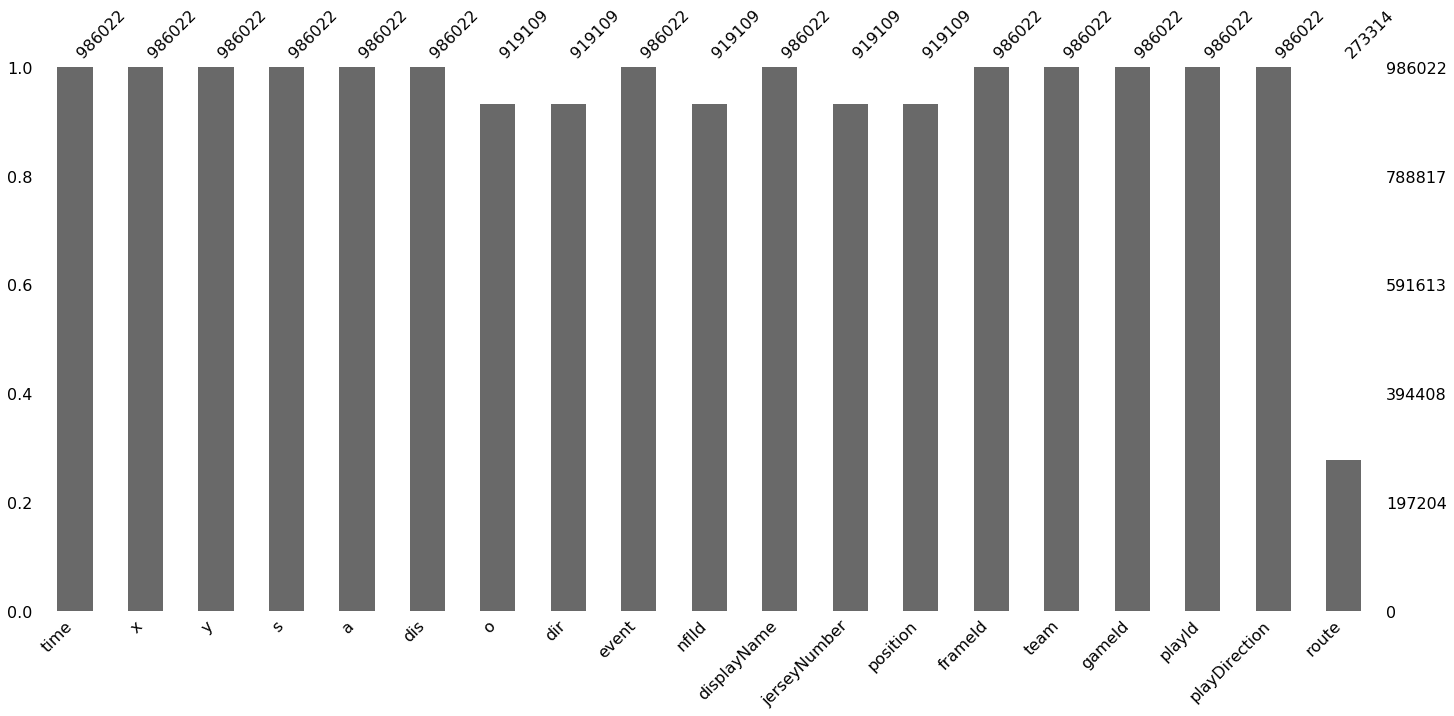

In [0]:
import missingno as msno
msno.bar(sp_week1.toPandas())
#This show the visualization about the missing number.